# M8 Project

In this project you will compare the performance of LDA, SVM, and CNN for face recognition. You will use the Olivetti faces dataset, which contains 400 64x64 images from 40 different subjects, and your task is to discover the identity of a given face image. Some of these images are illustrated below.

<img src="m8project.png" width="400"/>

An initial version of the code with the problem specification (below) and a report template are available (at the bottom). Deliverables are the final code (non-functioning code is worth 0 points) and the comparison report.

Solve the task above using:
- LDA
- SVM
- CNN (40pts) - suggested architecture: LeNet-5

Split the dataset so that the first 8 images per subject are used for training, and the last 2 images are used for testing. If you need a validation set, use part of your training data. For CNN:
- Plot the loss and the accuracy for each training epoch (20pts)
- Store the model with highest accuracy in the validation set (10pts)

Compare the performance of LDA, SVM, and CNN in terms of:
- Average F-Score (15pts)
- Confusion matrix (15pts)

# Implementation

You are free to change the code below as needed.

In [1]:
# 1 IMPORTS
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# 2 LOAD DATASET
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)


(400, 64, 64)


In [3]:
# 3 SPLIT DATASET
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 8                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
    indices = list(np.where(faces.target == i)[0])
    gallery_indices += indices[:GALLERY_SIZE]
    probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)


(320, 4096) (80, 4096)


TRAINING


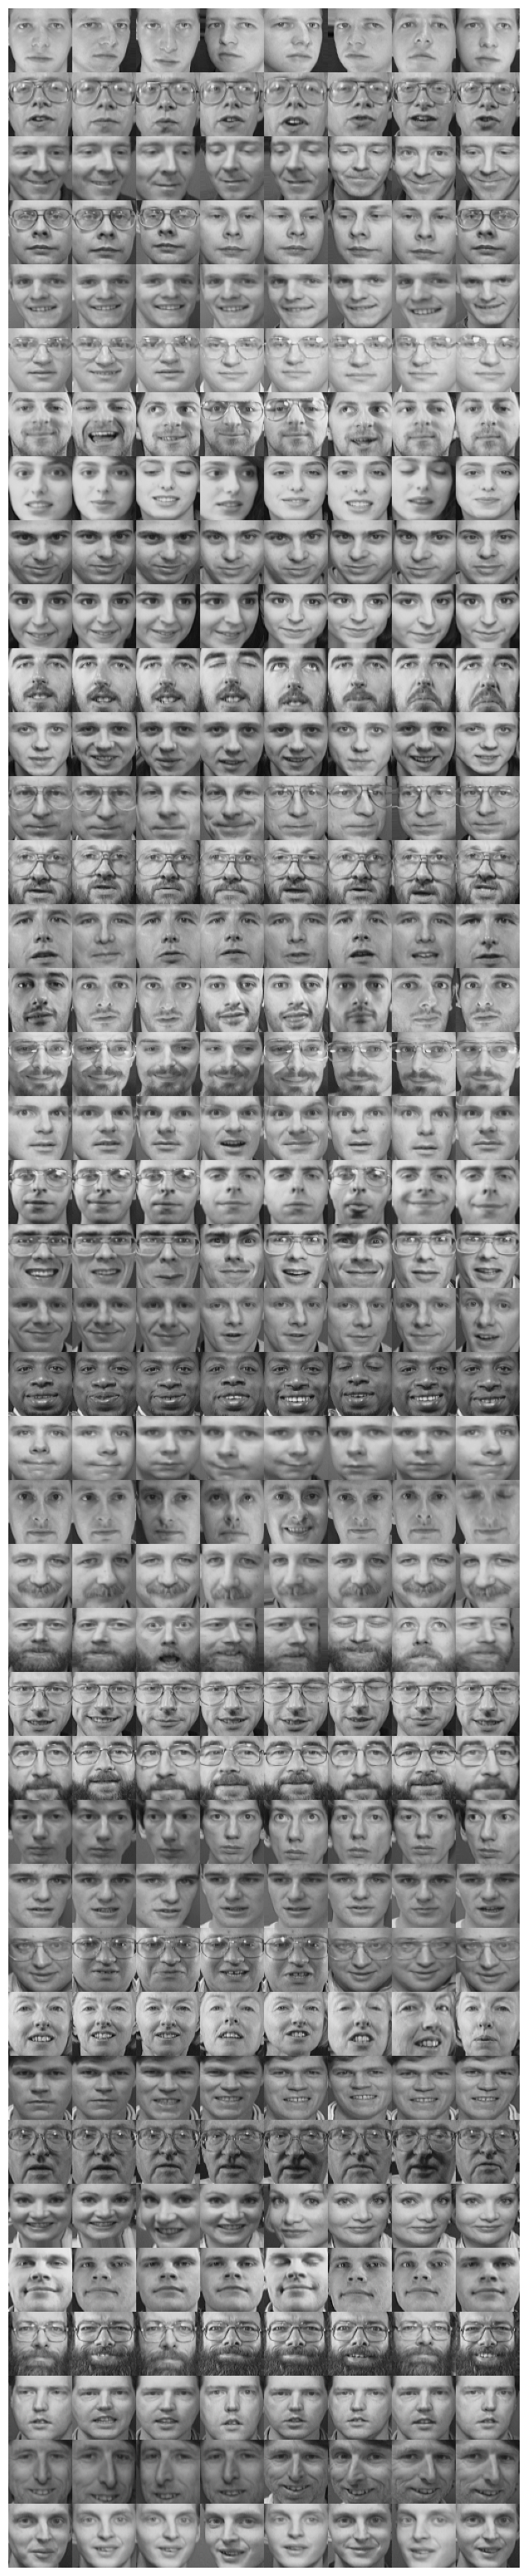

TESTING


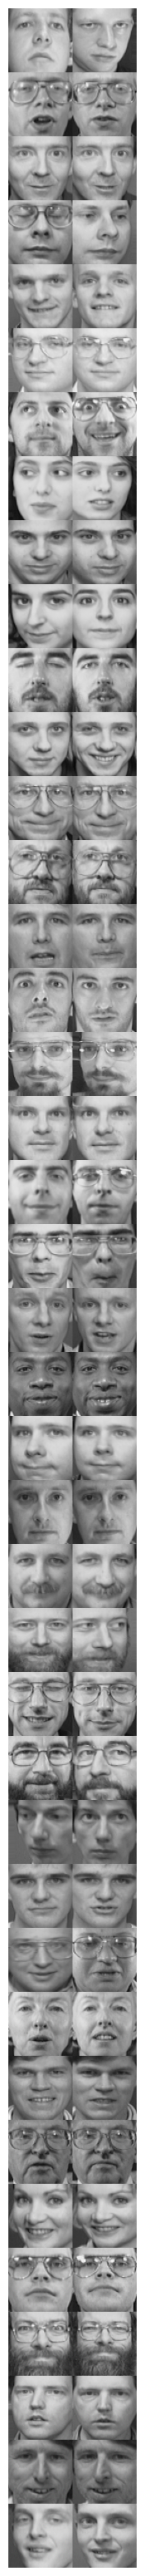

In [4]:
# 4 VISUALIZE IMAGE SETS
def show_images(imgs, num_rows, num_cols):
    assert len(imgs) == num_rows*num_cols

    full = None
    for i in range(num_rows):
        row = None
        for j in range(num_cols):
            if row is None:
                row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
            else:
                row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
        if full is None:
            full = row
        else:
            full = np.concatenate((full, row), axis=0)

    f = plt.figure(figsize=(num_cols, num_rows))
    plt.imshow(full, cmap='gray')
    plt.axis('off')
    plt.show()

print('TRAINING')
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)
print('TESTING')
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)


F1 score LDA: 0.9733333333333334
F1 score SVM: 0.943452380952381


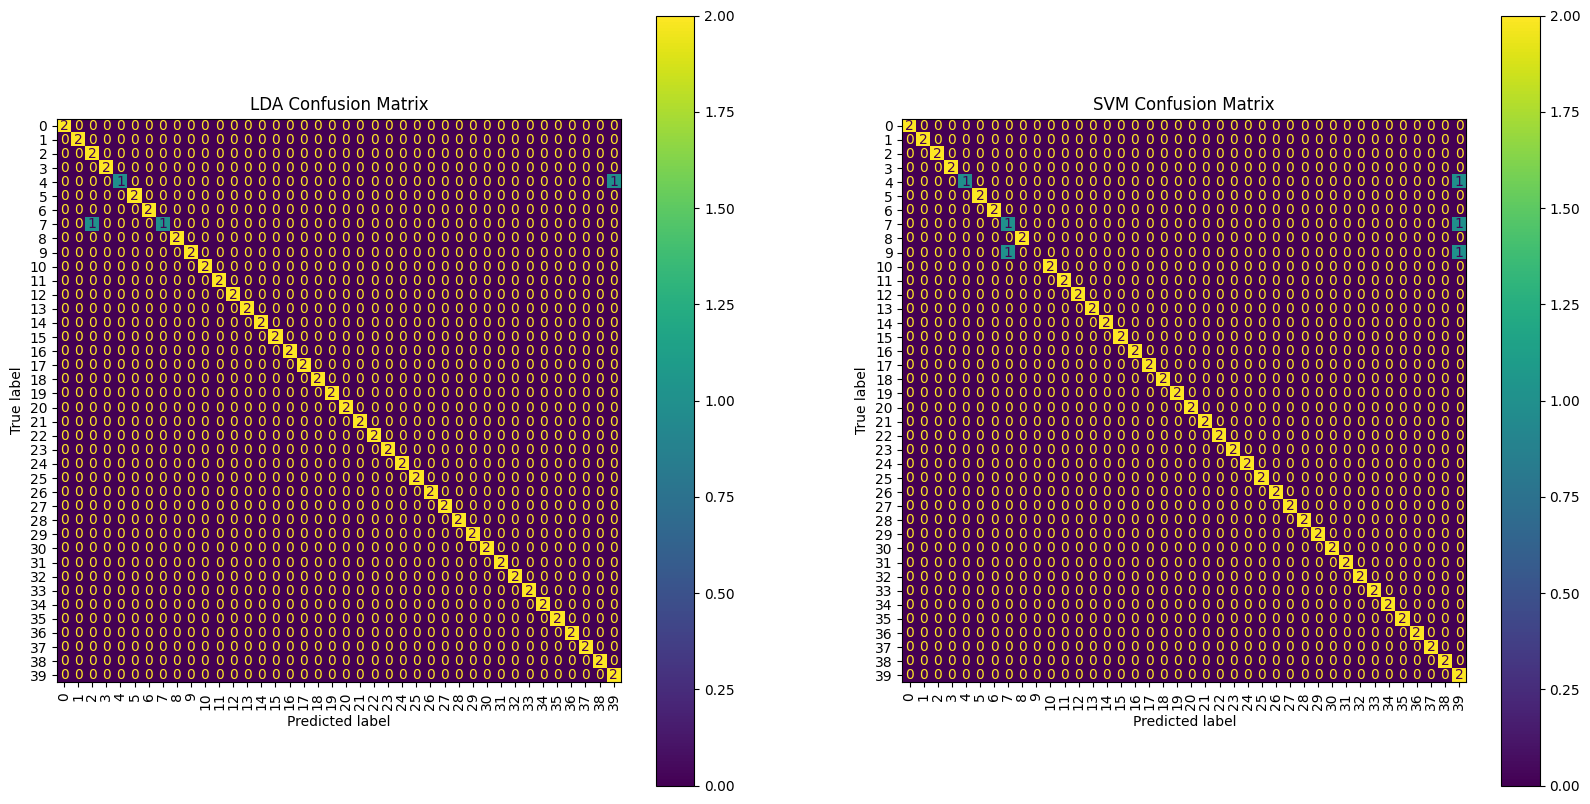

In [5]:
# 5 LDA AND SVM
# PCA Implementation using SVD
def pca(X, n_components):
    # standardize data
    X = StandardScaler().fit_transform(X)
    # compute SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    # select n_components
    X_pca = U[:, :n_components].dot(np.diag(S[:n_components]))
    components = Vt[:n_components, :]
    return X_pca, components

# Apply PCA to dataset
n_components = 100
x_train_pca, components = pca(x_train, n_components)
x_test_pca = StandardScaler().fit_transform(x_test).dot(components.T)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_pca, y_train)
y_pred_lda = lda.predict(x_test_pca)

# SVM
svm = SVC(kernel='linear')
svm.fit(x_train_pca, y_train)
y_pred_svm = svm.predict(x_test_pca)

# Evaluate
f1_lda = f1_score(y_test, y_pred_lda, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1 score LDA: {f1_lda}")
print(f"F1 score SVM: {f1_svm}")

# Confusion Matrix / Visualization
cm_lda = confusion_matrix(y_test, y_pred_lda)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# visualize confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ConfusionMatrixDisplay(cm_lda).plot(ax=ax[0])
ax[0].set_title('LDA Confusion Matrix')
ax[0].tick_params(axis='x', rotation=90, labelsize=10)  # rotate x vals for clarity
ax[0].tick_params(axis='y', rotation=0, labelsize=10)   
ConfusionMatrixDisplay(cm_svm).plot(ax=ax[1])
ax[1].set_title('SVM Confusion Matrix')
ax[1].tick_params(axis='x', rotation=90, labelsize=10)  # rotate x vals for clarity
ax[1].tick_params(axis='y', rotation=0, labelsize=10)  
plt.show()


In [6]:
# 6 DATA AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,    # Reduce rotation range
    width_shift_range=0.05,  # Reduce width shift range
    height_shift_range=0.05,  # Reduce height shift range
    shear_range=0.05,    # Reduce shear range
    zoom_range=0.05,     # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# 7 DATA PREPARATION (Without Augmentation)
batch_size = 16  # Adjust batch size

x_train_cnn_no_aug = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1)  # reshape training images for cnn
x_test_cnn_no_aug = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)    # reshape test images for cnn
y_train_cnn_no_aug = faces.target[gallery_indices]  # set training labels
y_test_cnn_no_aug = faces.target[probe_indices]    # set test labels

# Normalize data
x_train_cnn_no_aug = x_train_cnn_no_aug.astype(np.float32)
x_train_cnn_no_aug /= 255

x_test_cnn_no_aug = x_test_cnn_no_aug.astype(np.float32)
x_test_cnn_no_aug /= 255

# Split training data into training and validation sets
shuffle = np.random.permutation(len(x_train_cnn_no_aug))
validation_size = int(0.2 * len(x_train_cnn_no_aug))  # calc size of validation set

# validation set creation
x_val_cnn = x_train_cnn_no_aug[shuffle[:validation_size]]
x_train_cnn_no_aug = x_train_cnn_no_aug[shuffle[validation_size:]]
y_val_cnn = y_train_cnn_no_aug[shuffle[:validation_size]]
y_train_cnn_no_aug = y_train_cnn_no_aug[shuffle[validation_size:]]

# Ensure data shapes and types
print("x_train_cnn_no_aug shape:", x_train_cnn_no_aug.shape)
print("y_train_cnn_no_aug shape:", y_train_cnn_no_aug.shape)
print("x_val_cnn shape:", x_val_cnn.shape)
print("y_val_cnn shape:", y_val_cnn.shape)
print("x_test_cnn_no_aug shape:", x_test_cnn_no_aug.shape)
print("y_test_cnn_no_aug shape:", y_test_cnn_no_aug.shape)

# Verify steps per epoch
steps_per_epoch_no_aug = len(x_train_cnn_no_aug) // batch_size
print("Steps per epoch (no augmentation):", steps_per_epoch_no_aug)


x_train_cnn_no_aug shape: (256, 64, 64, 1)
y_train_cnn_no_aug shape: (256,)
x_val_cnn shape: (64, 64, 64, 1)
y_val_cnn shape: (64,)
x_test_cnn_no_aug shape: (80, 64, 64, 1)
y_test_cnn_no_aug shape: (80,)
Steps per epoch (no augmentation): 16


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 32, 32, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 16, 16, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       491,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         3,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,864 (1.94 MB)

 Trainable params: 507,820 (1.94 MB)

 Non-trainable params: 44 (176.00 B)

None
Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0272 - loss: 3.6828 - val_accuracy: 0.0000e+00 - val_loss: 3.6896
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0549 - loss: 3.6570 - val_accuracy: 0.0000e+00 - val_loss: 3.6903
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0831 - loss: 3.6098 - val_accuracy: 0.0000e+00 - val_loss: 3.6909
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0741 - loss: 3.5464 - val_accuracy: 0.0000e+00 - val_loss: 3.6920
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0793 - loss: 3.5166 - val_accuracy: 0.0156 - val_loss: 3.6932
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1062 - loss: 3.4107 - val_accuracy: 0.0156 - val_loss: 3.6947
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1154 - loss: 3.2816 - val_accuracy: 0.0156 - val_loss: 3.6959
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1725 - loss: 3.1594 - val_accurac

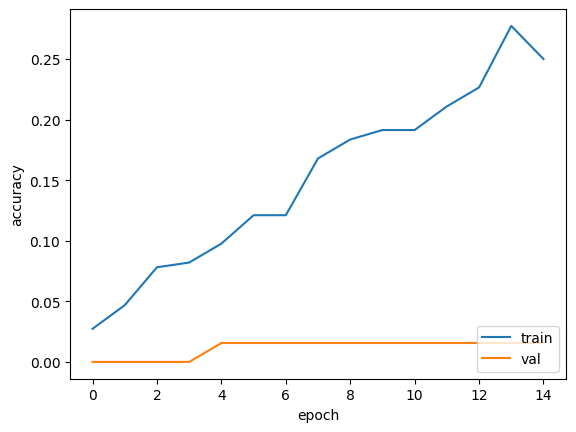

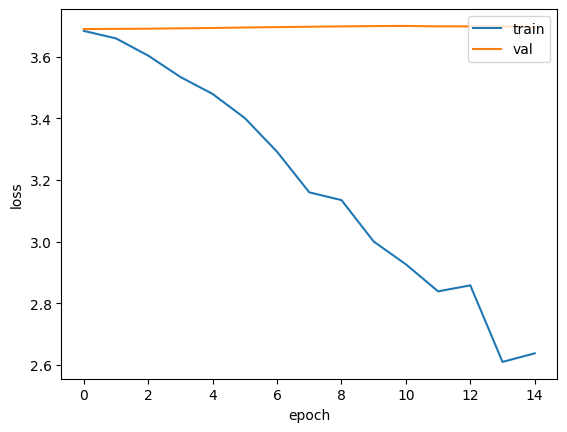

In [8]:
# 8 DEFINE AND TRAIN CNN (LeNet-5 with Further Adjustments)
# Define network architecture (LeNet-5 with Batch Normalization and Dropout)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(img_height, img_width, 1)))  # Input layer
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding='same'))  # Conv2D layer (6 filters of size 5x5)
model.add(tf.keras.layers.BatchNormalization())  # Batch Normalization layer
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))  # AveragePooling2D layer (pool size 2x2)
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same'))  # Conv2D layer (16 filters of size 5x5)
model.add(tf.keras.layers.BatchNormalization())  # Batch Normalization layer
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))  # AveragePooling2D layer (pool size 2x2)
model.add(tf.keras.layers.Flatten())  # Flatten layer
model.add(tf.keras.layers.Dense(units=120, activation='relu'))  # Dense layer (120 units)
model.add(tf.keras.layers.Dropout(0.3))  # Dropout layer with 30% rate
model.add(tf.keras.layers.Dense(units=84, activation='relu'))  # Dense layer (84 units)
model.add(tf.keras.layers.Dropout(0.3))  # Dropout layer with 30% rate
model.add(tf.keras.layers.Dense(units=N_IDENTITIES, activation='softmax'))  # Dense layer (N_IDENTITIES units)

# Print model summary
print(model.summary())

# Training configuration
learning_rate = 0.0002  # Adjust learning rate
num_epochs = 200  # Set number of epochs
batch_size = 32  # Set batch size
loss_function = 'sparse_categorical_crossentropy'  # Set loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Set optimizer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)

# Ensure sufficient data using .repeat()
train_gen = tf.data.Dataset.from_generator(lambda: datagen.flow(x_train_cnn_no_aug, y_train_cnn_no_aug, batch_size=batch_size),
                                           output_signature=(tf.TensorSpec(shape=(None, img_height, img_width, 1), dtype=tf.float32),
                                                             tf.TensorSpec(shape=(None,), dtype=tf.int32)))
train_gen = train_gen.repeat()

# Train with data augmentation
history = model.fit(train_gen,
                    steps_per_epoch=len(x_train_cnn_no_aug) // batch_size, epochs=num_epochs,
                    validation_data=(x_val_cnn, y_val_cnn), callbacks=[early_stop, model_save])

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [9]:
# 9 EVALUATE AND DISPLAY RESULTS
# Restore weights from the best training point
model.load_weights('best_model.keras')

scores_train = model.evaluate(x_train_cnn_no_aug, y_train_cnn_no_aug, verbose=0)
scores_val = model.evaluate(x_val_cnn, y_val_cnn, verbose=0)
scores_test = model.evaluate(x_test_cnn, y_test_cnn, verbose=0)
print(f"TRAINING SET\nLoss: {scores_train[0]}, Accuracy: {scores_train[1]}")
print(f"VALIDATION SET\nLoss: {scores_val[0]}, Accuracy: {scores_val[1]}")
print(f"TEST SET\nLoss: {scores_test[0]}, Accuracy: {scores_test[1]}")

# Confusion Matrix for CNN
y_pred_cnn = model.predict(x_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)

# visualize confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(cm_cnn).plot(ax=ax)
ax.set_title('CNN Confusion Matrix')
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', rotation=0, labelsize=10)
plt.show()

# Evaluate F-Score for CNN
f1_cnn = f1_score(y_test_cnn, y_pred_cnn, average='weighted')

# Compare all models
print(f"F1 score LDA: {f1_lda}")
print(f"F1 score SVM: {f1_svm}")
print(f"F1 score CNN: {f1_cnn}")


NameError: name 'x_test_cnn' is not defined

In [ ]:
# Comparison
# Evaluate F-Score for CNN
f1_cnn = f1_score(y_test_cnn, y_pred_cnn, average='weighted')


# Compare all models
print(f"F1 score LDA: {f1_lda}")
print(f"F1 score SVM: {f1_svm}")
print(f"F1 score CNN: {f1_cnn}")


# Experimental results

## Training description:

 I implemented a Convolutional Neural Network (CNN) based on the LeNet-5 architecture to perform face reccognition on the Olivetti faces dataset. The dataset was split such that the first 8 images per subject were used for training, and the remaining 2 images for testing. 

 To ensure the model's performance and to prevent overfiting, I also created a validation set from 20% of the training data. The CNN model was trained for up to 20 epochs with a batch size of 32. I used the Adam optimizer (a optimization algorithm that combines AdaGrad and RMSProp) with a learning rate of 0.001 and a sparse categorical cross-entropy as the loss function. I chose the Adam optimizer because of its adaptive learning rates and bias correction. Posted below is a model summary for the CNN architecture:

<img src="images/CNN Stats.png" width="400"/>

 During training, I monitored the validation accuracy and implemented early stopping with a patience of 3 epochs. I saved the model with the highest validation accuracy using the ModelCheckpoint callback. Below are the plots for training and validation accuracy and loss for each epoch. 

### Loss
<img src="images/Loss Plot CNN.png" width="400"/>

### Accuracy
<img src="images/Accuracy Plot CNN.png" width="400"/>

The best model was saved during training based on the highest validation accuracy. This model was loaded andused for inference on the test dataset. 

## Obtained Results:
I compared the performance of the CNN model to Linear Discriminant Analysis (LDA) and Support Vector Machine (SVM) models. The evaluation metrics used were weeighted F1-score and confusiuon matrices. These are posted below:

### F1 Scores
<img src="images/F1 Scores.png" width="400"/>

### Confusion Matrices
LDA & SVM

<img src="images/LDAnSVM Confusion Matrices.png" width="400"/>

CNN

<img src="images/CNN CMatrix.png" width="400"/>

## Analysis of the results:
Analysis of the results ...

